Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MultiScaleFeatureExtractor - Input: torch.Size([1, 2, 225, 300])
MultiScaleFeatureExtractor - original_img: torch.Size([1, 1, 225, 300])
MultiScaleFeatureExtractor - noisy_img: torch.Size([1, 1, 225, 300])
DilatedConvLayer (dilation=1) - Input: torch.Size([1, 1, 225, 300])
DilatedConvLayer (dilation=1) - conv output: torch.Size([1, 64, 225, 300])
DilatedConvLayer (dilation=1) - Output: torch.Size([1, 64, 225, 300])
SpatialAttention - Input: torch.Size([1, 64, 225, 300])
SpatialAttention - avg_out: torch.Size([1, 1, 225, 300])
SpatialAttention - max_out: torch.Size([1, 1, 225, 300])
SpatialAttention - concatenated: torch.Size([1, 2, 225, 300])
SpatialAttention - conv1 output: torch.Size([1, 1, 225, 300])
SpatialAttention - Output: torch.Size([1, 64, 225, 300])
ChannelAttention - Input: torch.Size([1, 64, 225, 300])
ChannelAttention - avg_out: torch.Size([1, 64

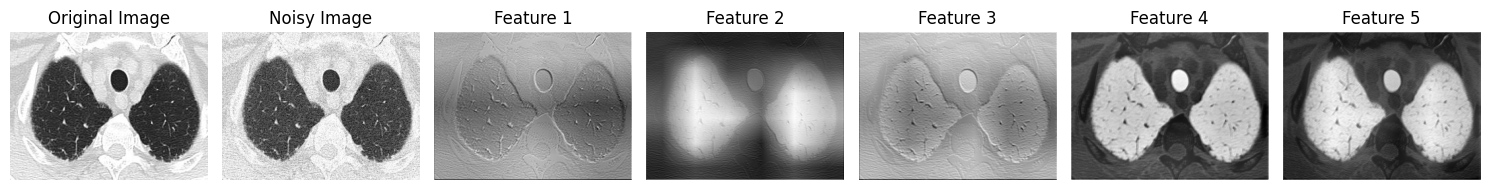

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
from google.colab import drive
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print("SpatialAttention - Input:", x.shape)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        print("SpatialAttention - avg_out:", avg_out.shape)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        print("SpatialAttention - max_out:", max_out.shape)
        y = torch.cat([avg_out, max_out], dim=1)
        print("SpatialAttention - concatenated:", y.shape)
        y = self.conv1(y)
        print("SpatialAttention - conv1 output:", y.shape)
        output = self.sigmoid(y) * x
        print("SpatialAttention - Output:", output.shape)
        return output

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print("ChannelAttention - Input:", x.shape)
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        print("ChannelAttention - avg_out:", avg_out.shape)
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        print("ChannelAttention - max_out:", max_out.shape)
        out = avg_out + max_out
        print("ChannelAttention - summed output:", out.shape)
        output = self.sigmoid(out) * x
        print("ChannelAttention - Output:", output.shape)
        return output

class DilatedConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(DilatedConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rate, dilation=dilation_rate)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        print(f"DilatedConvLayer (dilation={self.conv.dilation[0]}) - Input:", x.shape)
        conv_out = self.conv(x)
        print(f"DilatedConvLayer (dilation={self.conv.dilation[0]}) - conv output:", conv_out.shape)
        relu_out = self.relu(conv_out)
        print(f"DilatedConvLayer (dilation={self.conv.dilation[0]}) - Output:", relu_out.shape)
        return relu_out

class PyramidPoolingLayer(nn.Module):
    def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
        super(PyramidPoolingLayer, self).__init__()
        self.pools = nn.ModuleList()
        for size in pool_sizes:
            self.pools.append(nn.AdaptiveAvgPool2d(size))

    def forward(self, x):
        print("PyramidPoolingLayer - Input:", x.shape)
        batch_size, channels, height, width = x.size()
        pooled_outputs = [x]
        print("PyramidPoolingLayer - initial pooled_outputs[0]:", pooled_outputs[0].shape)
        for i, pool in enumerate(self.pools):
            pooled = pool(x)
            print(f"PyramidPoolingLayer - pooled (size={pool.output_size}):", pooled.shape)
            pooled = F.interpolate(pooled, size=(height, width), mode='bilinear', align_corners=False)
            print(f"PyramidPoolingLayer - interpolated pooled (size={pool.output_size}):", pooled.shape)
            pooled_outputs.append(pooled)
        output = torch.cat(pooled_outputs, dim=1)
        print("PyramidPoolingLayer - Output (concatenated):", output.shape)
        return output

class MultiScaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleFeatureExtractor, self).__init__()
        dcl_out_channels = 64
        ppl_out_mult = len(PyramidPoolingLayer(1).pools) + 1 # 4 + 1 = 5

        # Branch 1 (processes original)
        self.dcl1 = DilatedConvLayer(1, dcl_out_channels, dilation_rate=1)
        self.sa1 = SpatialAttention()
        self.ca1 = ChannelAttention(dcl_out_channels)
        self.ppl1 = PyramidPoolingLayer(dcl_out_channels)
        self.conv1_1 = nn.Conv2d(dcl_out_channels * ppl_out_mult, dcl_out_channels, kernel_size=1)

        # Branch 2 (processes original)
        self.dcl2 = DilatedConvLayer(1, dcl_out_channels, dilation_rate=2)
        self.sa2 = SpatialAttention()
        self.ca2 = ChannelAttention(dcl_out_channels)
        self.ppl2 = PyramidPoolingLayer(dcl_out_channels)
        self.conv2_1 = nn.Conv2d(dcl_out_channels * ppl_out_mult, dcl_out_channels, kernel_size=1)

        # Branch 3 (processes noisy)
        dcl4_out_channels = dcl_out_channels // 2
        dcl8_out_channels = dcl_out_channels // 2
        self.dcl4 = DilatedConvLayer(1, dcl4_out_channels, dilation_rate=4)
        self.dcl8 = DilatedConvLayer(1, dcl8_out_channels, dilation_rate=8)
        self.sa3 = SpatialAttention()
        self.ca3 = ChannelAttention(dcl4_out_channels + dcl8_out_channels)
        self.ppl3 = PyramidPoolingLayer(dcl4_out_channels + dcl8_out_channels)
        self.conv3_1 = nn.Conv2d((dcl4_out_channels + dcl8_out_channels) * ppl_out_mult, dcl_out_channels, kernel_size=1)

        # Final Fusion
        self.final_conv = nn.Conv2d(dcl_out_channels * 3, 256, kernel_size=1)

    def forward(self, combined_input):
        print("MultiScaleFeatureExtractor - Input:", combined_input.shape)
        # Split the combined input
        original_img = combined_input[:, 0:1, :, :]
        print("MultiScaleFeatureExtractor - original_img:", original_img.shape)
        noisy_img = combined_input[:, 1:2, :, :]
        print("MultiScaleFeatureExtractor - noisy_img:", noisy_img.shape)

        # Branch 1
        fe1 = self.dcl1(original_img)
        attn1 = self.sa1(fe1) + self.ca1(fe1)
        ppl1_out = self.ppl1(attn1)
        f1 = self.conv1_1(ppl1_out)
        print("MultiScaleFeatureExtractor - Branch 1 f1:", f1.shape)

        # Branch 2
        fe2 = self.dcl2(original_img)
        attn2 = self.sa2(fe2) + self.ca2(fe2)
        ppl2_out = self.ppl2(attn2)
        f2 = self.conv2_1(ppl2_out)
        print("MultiScaleFeatureExtractor - Branch 2 f2:", f2.shape)

        # Branch 3
        fe4 = self.dcl4(noisy_img)
        fe8 = self.dcl8(noisy_img)
        fe_concat = torch.cat([fe4, fe8], dim=1)
        print("MultiScaleFeatureExtractor - Branch 3 fe_concat:", fe_concat.shape)
        attn3 = self.sa3(fe_concat) + self.ca3(fe_concat)
        ppl3_out = self.ppl3(attn3)
        f3 = self.conv3_1(ppl3_out)
        print("MultiScaleFeatureExtractor - Branch 3 f3:", f3.shape)

        # The multi-scale features before final fusion
        self.intermediate_features = torch.cat([f1, f2, f3], dim=1)
        print("MultiScaleFeatureExtractor - intermediate_features:", self.intermediate_features.shape)
        final_features = self.final_conv(self.intermediate_features)
        print("MultiScaleFeatureExtractor - final_features:", final_features.shape)
        return final_features

if __name__ == '__main__':
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define paths to your folders
    original_folder = '/content/drive/MyDrive/CT_image_MsADC_SR_Net/Original'  # Replace with your actual path
    noisy_folder = '/content/drive/MyDrive/CT_image_MsADC_SR_Net/Noisy'    # Replace with your actual path

    # Get lists of image files
    original_files = [f for f in os.listdir(original_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    noisy_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    image_pairs = []
    for original_file in original_files:
        base_name, ext = os.path.splitext(original_file)
        noisy_match = [f for f in noisy_files if base_name in f]
        if noisy_match:
            image_pairs.append((os.path.join(original_folder, original_file), os.path.join(noisy_folder, noisy_match[0])))

    if not image_pairs:
        print("No matching original and noisy image pairs found.")
    else:
        # Process the first image pair for visualization
        original_path, noisy_path = image_pairs[0]
        try:
            original_img_pil = Image.open(original_path).convert('L')
            noisy_img_pil = Image.open(noisy_path).convert('L')
        except FileNotFoundError:
            print(f"Error: One or both image files not found for pair: {original_path}, {noisy_path}")
        else:
            transform = transforms.Compose([transforms.ToTensor()])
            in_channels = 2
            model = MultiScaleFeatureExtractor(in_channels)
            model.eval() # Set to evaluation mode

            original_img_tensor = transform(original_img_pil).unsqueeze(0) # [1, 1, height, width]
            noisy_img_tensor = transform(noisy_img_pil).unsqueeze(0) # [1, 1, height, width]
            combined_input = torch.cat([original_img_tensor, noisy_img_tensor], dim=1) # [1, 2, height, width]

            with torch.no_grad():
                _ = model(combined_input) # Forward pass to populate intermediate_features
                multi_scale_features = model.intermediate_features # [1, 192, height, width]

            print("Combined Input shape:", combined_input.shape)
            print("Multi-Scale Features shape:", multi_scale_features.shape)

            # Visualize some of the multi-scale features (first few channels)
            num_features_to_visualize = min(multi_scale_features.shape[1], 5)
            fig, axes = plt.subplots(1, num_features_to_visualize + 2, figsize=(15, 5))

            axes[0].imshow(original_img_pil, cmap='gray')
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(noisy_img_pil, cmap='gray')
            axes[1].set_title('Noisy Image')
            axes[1].axis('off')

            for i in range(num_features_to_visualize):
                feature_map = multi_scale_features[0, i, :, :].cpu().numpy()
                axes[i + 2].imshow(feature_map, cmap='gray')
                axes[i + 2].set_title(f'Feature {i+1}')
                axes[i + 2].axis('off')

            plt.tight_layout()
            plt.show()